In [37]:
import re
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
import torch
from torch.utils.data import DataLoader

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer
from transformers import BartTokenizer, BartForConditionalGeneration

In [3]:
user = "....."

##### Training

In [4]:
cache_path = f"/scratch/{user}/datasets"
dataset = load_dataset(
    "causality-grammar/logic_explanations",
    data_files={"train": "deepseek_5k_RP.parquet"},
    cache_dir=cache_path
)

In [16]:
cache_path = f"/scratch/{user}/models"
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", cache_dir=cache_path)
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base", device_map="auto", cache_dir=cache_path)

In [5]:
cache_path = f"/scratch/{user}/models"
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir=cache_path)
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base', device_map="auto", cache_dir=cache_path)

In [6]:
# --- 3. Preprocess the Data ---
# This function remains the same as before.
def preprocess_function(sample):
    source = (
        f"Answer the question based on the provided context.\n\nYour Final answer should be 0 (if False) and 1 (if True)\n\n"
        f"Question: {sample['Question']}\n\n"
        f"Answer: "
    )
    target = f"{sample['Complex_CoT']} Answer: {sample['Response']}"
    tokenized_source = tokenizer(source, max_length=1024, truncation=True)
    tokenized_target = tokenizer(target, max_length=256, truncation=True)
    tokenized_source["labels"] = tokenized_target["input_ids"]
    return tokenized_source

In [8]:
print("Preprocessing dataset...")
tokenized_dataset = dataset.map(preprocess_function, remove_columns=dataset['train'].column_names)

Preprocessing dataset...


In [ ]:
# --- 4. Train the Model ---
print("Setting up training...")

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model
)

# Training arguments for full fine-tuning
# You may need a smaller batch size and use gradient accumulation
# to fit this into memory.
finetuned_model_output_dir = f"/scratch/{user}/models/bart_finetuned_new"
training_args = TrainingArguments(
    output_dir=finetuned_model_output_dir,
    per_device_train_batch_size=2,  # Lowered batch size for full model
    gradient_accumulation_steps=4, # Accumulate gradients to simulate a larger batch size
    learning_rate=5e-5, # A common learning rate for full fine-tuning
    num_train_epochs=3,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="epoch",
    report_to="none"
)

# The Trainer uses the full model directly
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start training!
print("Starting full fine-tuning...")
trainer.train()

# Save the fully fine-tuned model and tokenizer
print("Saving the full model...")
trainer.save_model(finetuned_model_output_dir)
tokenizer.save_pretrained(finetuned_model_output_dir)

print("✅ Full fine-tuning complete!")

Setting up training...


NameError: name 'tokenizer' is not defined

#### Inference

In [4]:
def create_prompt(question_text):
    """Creates a standardized prompt for the models."""
    return f"Answer the question based on the provided context.\n\nYour Final answer should be 0 (if False) and 1 (if True)\n\nQuestion: {question_text}\n\nAnswer:"

In [5]:
def get_seq2seq_batch_predictions(model, tokenizer, prompts):
    """Gets predictions for a batch of prompts from a local Seq2Seq model."""
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)
    with torch.no_grad():
        output_sequences = model.generate(**inputs, max_new_tokens=2048, do_sample=False)
    return tokenizer.batch_decode(output_sequences, skip_special_tokens=True)

In [6]:
def parse_final_answer(text):
    """Extracts the final integer answer from the generated text."""
    match = re.search(r"Answer: (\d+)", text, re.IGNORECASE)
    if match:
        try: return int(match.group(1))
        except (ValueError, IndexError): return -1
    return -1

In [7]:
def plot_confusion_matrix(cm, classes, title):
    """Plots a confusion matrix using seaborn."""
    plt.figure(figsize=(6, 5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title); plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.show()

In [72]:
model_path = f"/scratch/{user}/models/bart_finetuned_new"
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path, device_map="auto")

In [10]:
cache_path = f"/scratch/{user}/datasets"
test_dataset = load_dataset(
    "causality-grammar/logic_explanations",
    data_files={"test": "deepseek_3.6k_RP_test.parquet"},
    cache_dir=cache_path
)["test"]

In [11]:
all_prompts = [create_prompt(ex['Question']) for ex in test_dataset]
all_true_labels = [ex['Response'] for ex in test_dataset]
all_depths = [ex['Depth'] for ex in test_dataset]

In [24]:
bart_preds = []
bart_proof_chains = []
BATCH_SIZE = 32
prompt_loader = DataLoader(all_prompts, batch_size=BATCH_SIZE)

In [25]:
for batch in tqdm(prompt_loader, desc="BART Batches"):
    outputs = get_seq2seq_batch_predictions(model, tokenizer, batch)
    bart_proof_chains.extend(outputs)
    bart_preds.extend([parse_final_answer(out) for out in outputs])

BART Batches: 100%|██████████| 113/113 [05:37<00:00,  2.98s/it]


In [69]:
results = []
for i in range(len(all_prompts)):
    results.append({
        "depth": all_depths[i], "true_label": all_true_labels[i],
        "bart_pred": bart_preds[i] if bart_preds else -1,
        "bart_proof_chain": bart_proof_chains[i]
        # "local_comp_pred": local_comp_preds[i] if local_comp_preds else -1,
        # "deepseek_api_pred": deepseek_api_preds[i] if deepseek_api_preds else -1,
    })


***** Evaluation Results *****

Overall BART Accuracy: 0.7397

--- Depth-wise Analysis ---

--- Depth: 0 (300 examples) ---
  bart Accuracy: 0.9933


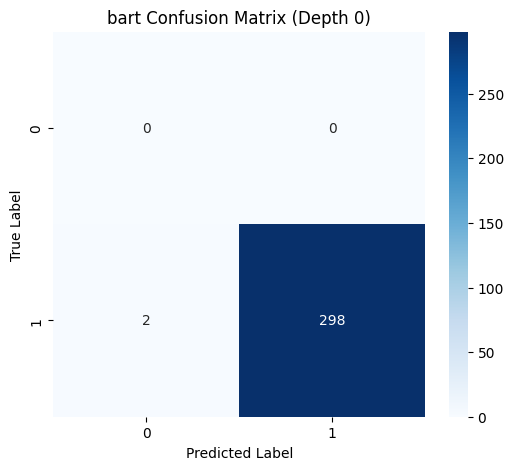


--- Depth: 1 (300 examples) ---
  bart Accuracy: 0.9833


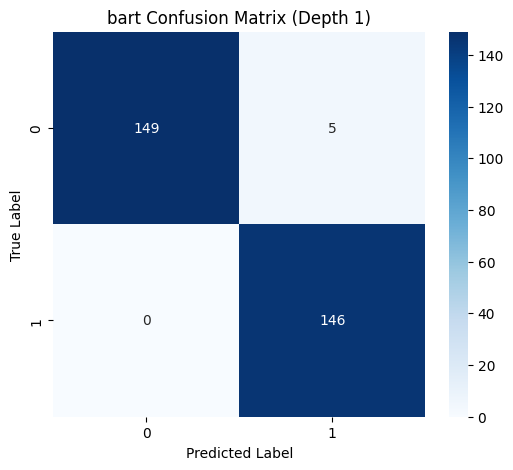


--- Depth: 2 (300 examples) ---
  bart Accuracy: 0.7800


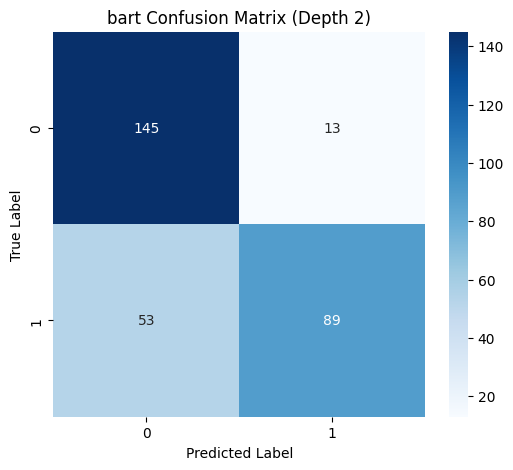


--- Depth: 3 (300 examples) ---
  bart Accuracy: 0.7800


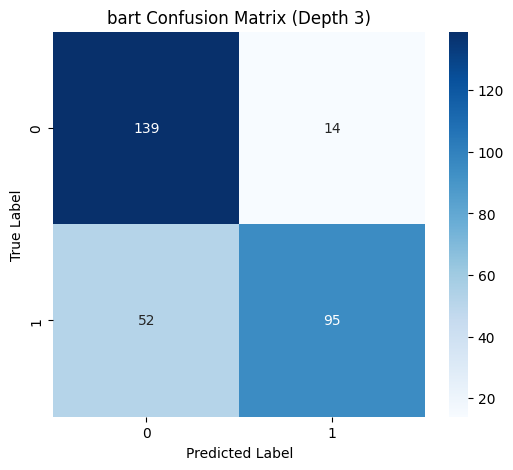


--- Depth: 4 (300 examples) ---
  bart Accuracy: 0.7200


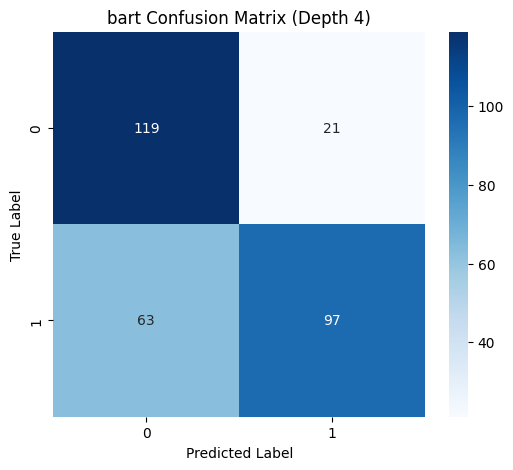


--- Depth: 5 (300 examples) ---
  bart Accuracy: 0.7033


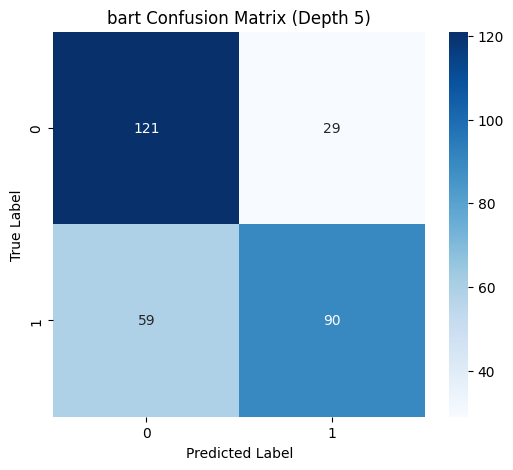


--- Depth: 6 (300 examples) ---
  bart Accuracy: 0.7367


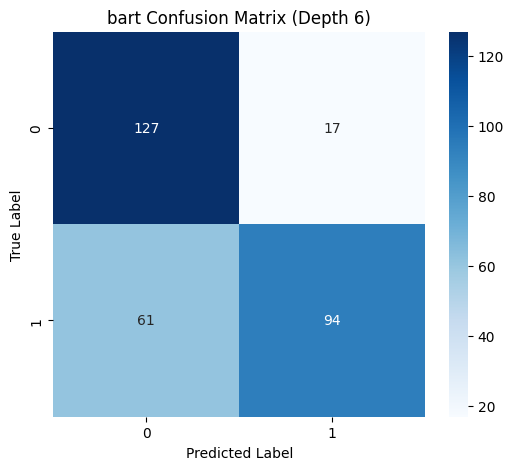


--- Depth: 7 (300 examples) ---
  bart Accuracy: 0.6733


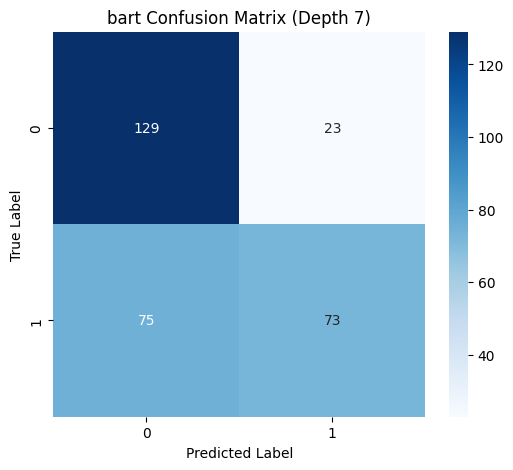


--- Depth: 8 (300 examples) ---
  bart Accuracy: 0.6967


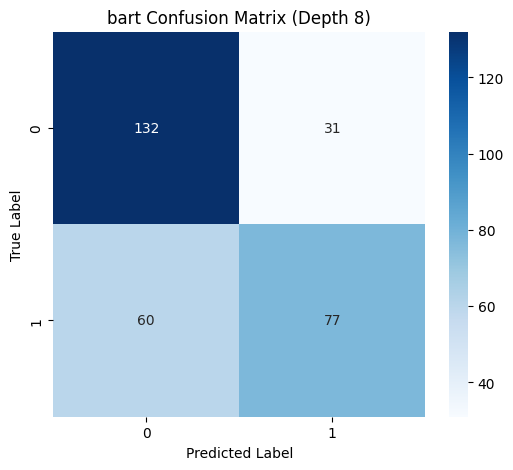


--- Depth: 9 (300 examples) ---
  bart Accuracy: 0.6067


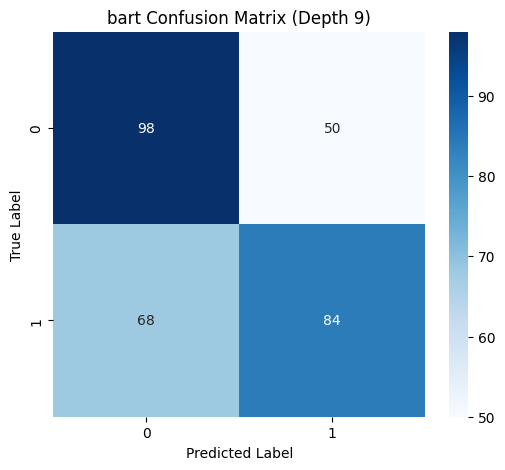


--- Depth: 10 (300 examples) ---
  bart Accuracy: 0.6000


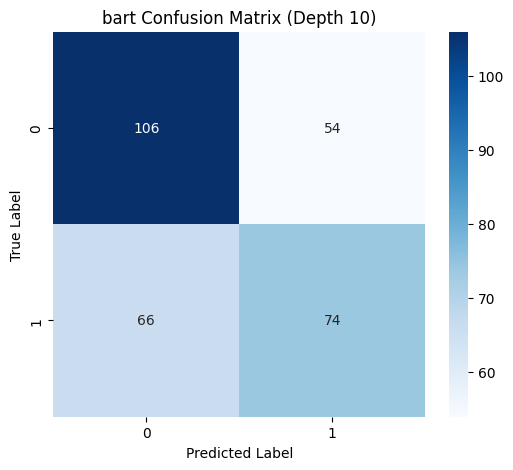


--- Depth: 11 (300 examples) ---
  bart Accuracy: 0.6033


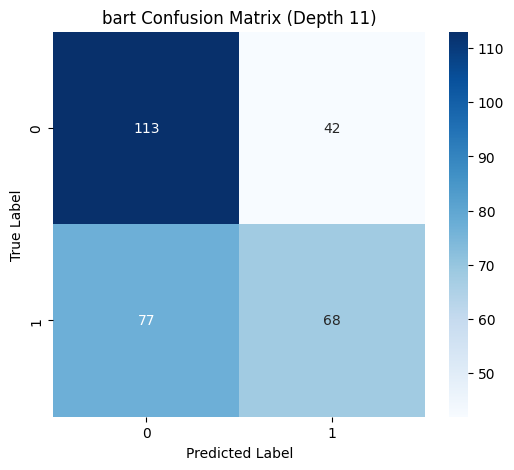

In [45]:
print("\n***** Evaluation Results *****")
accuracy_by_depth = {"depth": list(), "accuracy": list()}
results_by_depth = defaultdict(list)
for res in results: results_by_depth[res['depth']].append(res)
sorted_depths = sorted(results_by_depth.keys())

# --- Overall Accuracy ---
print(f"\nOverall BART Accuracy: {accuracy_score(all_true_labels, bart_preds):.4f}")

print("\n--- Depth-wise Analysis ---")
for depth in sorted_depths:
    depth_results = results_by_depth[depth]
    true_labels = [r['true_label'] for r in depth_results]
    print(f"\n--- Depth: {depth} ({len(depth_results)} examples) ---")

    model_preds = {
        "bart": [r['bart_pred'] for r in depth_results] if bart_preds else None,
        # LOCAL_COMPARISON_MODEL_ID: [r['local_comp_pred'] for r in depth_results] if local_comp_preds else None,
        # "DeepSeek API": [r['deepseek_api_pred'] for r in depth_results] if deepseek_api_preds else None,
    }

    for name, preds in model_preds.items():
        if preds:
            acc = accuracy_score(true_labels, preds)
            print(f"  {name} Accuracy: {acc:.4f}")
            cm = confusion_matrix(true_labels, preds, labels=[0, 1])
            plot_confusion_matrix(cm, classes=['0', '1'], title=f'{name} Confusion Matrix (Depth {depth})')

            accuracy_by_depth["depth"].append(depth)
            accuracy_by_depth["accuracy"].append(np.round(acc, 4))

In [50]:
import pandas as pd
df = pd.DataFrame(accuracy_by_depth).rename(columns={'depth': 'Depth', 'accuracy': 'BART Accuracy (3600 Samples)'})

In [53]:
print(df.to_string(index=False))

 Depth  BART Accuracy (3600 Samples)
     0                        0.9933
     1                        0.9833
     2                        0.7800
     3                        0.7800
     4                        0.7200
     5                        0.7033
     6                        0.7367
     7                        0.6733
     8                        0.6967
     9                        0.6067
    10                        0.6000
    11                        0.6033


In [70]:
import json
file_path = "../data/bart_proof_chains.txt"
with open(file_path, "w") as f:
    json.dump(results, f)

In [73]:
hub_repo_id = "causality-grammar/bart-base-fullfinetuned_40k"
print("Pushing model to the Hub...")
# Push the model to the Hub
model.push_to_hub(
    repo_id=hub_repo_id,
    commit_message="Initial model upload"
)

print("Pushing tokenizer to the Hub...")
# Push the tokenizer to the same repository
tokenizer.push_to_hub(
    repo_id=hub_repo_id,
    commit_message="Upload tokenizer"
)

print(f"✅ Model successfully pushed to {hub_repo_id}")

Pushing model to the Hub...


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmp0q_bvgj8/model.safetensors    :   0%|          |  131kB /  558MB            

Pushing tokenizer to the Hub...
✅ Model successfully pushed to causality-grammar/bart-base-fullfinetuned_40k
